## Multimodal Face Detection Model Based on Mask RCNN

In [2]:
# train infrared image object detection models
print("hello, infrared image!")
import warnings
warnings.filterwarnings("ignore")

hello, infrared image!


In [3]:
%pip install quick-csv==0.0.6a0

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [4]:
from quickcsv.file import *
import os

DIM=128

root_path=fr'G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\thermal_{DIM}'

dataset_path=fr'G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\list_face_detection_{DIM}_merged.csv'

list_item=read_csv(dataset_path)
print('No. images: ',len(list_item))

TRAIN_SIZE = int(len(list_item)*0.8)
VAL_SIZE=int(len(list_item)*0.2)



Read CSV: ['name', 'masks', 'labels']  <- (G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\list_face_detection_128_merged.csv)
No. images:  2935


In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
# print(tf.__version__)


os.environ['CUDA_VISIBLE_DEVICES']='-1'

# tf 1.13
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.ConfigProto(gpu_options=gpu_options)
# config.gpu_options.per_process_gpu_momory_fraction=0.7
# config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# tf 2.0
# gpu = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)
# gpu = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[1], True)

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "logs2-full"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)





correct directory imported


Using TensorFlow backend.


In [6]:
class Infrared2Config(Config):
    """Configuration for training on the toy infrared dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "infrared"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 9  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape. Default = 128
    IMAGE_MIN_DIM = DIM
    IMAGE_MAX_DIM = DIM

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs. 32
    TRAIN_ROIS_PER_IMAGE = 5

    # Use a small epoch since the data is simple, Default =100
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
 
    
config = Infrared2Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'bdry_score_loss': 1.0}
MASK_POOL_SIZE                 14

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:

class Infrared2Dataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    
    def load_dataset(self,list_item,start,end):
        
        self.list_item=list_item
        
        all_classes='chin|leyebrow|reyebrow|centernose|bottomnose|leye|reye|outermouth|innermouth'.split('|')
        
        
        # only one class
        for idx,c in enumerate(all_classes):
            self.add_class("infrared2", idx+1, c)
        
        # load properties
        total_count=0
        for idx,item in enumerate( list_item[start:end+1]):
            image_path=root_path+"/"+item['name']+'.png'
            # print(image_path)
            # print(item['name'])
            self.add_image("infrared2",image_id=idx,path=image_path,name=item['name'])
            total_count+=1
        # print(f"loaded {total_count}")
    
    def draw_shape(self, image, shape, shape_points,color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        

        points = np.array([shape_points], dtype=np.int32)
        cv2.fillPoly(image, points, 1)
        
        # cv2.rectangle(image, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), color, -1)
        # cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), color, -1)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        if info["source"] == "infrared":
            info = self.image_info[image_id]
            return info
        else:
            super(self.__class__).image_reference(self, image_id)



    def load_mask(self, image_id):
        # print("image name: ",self.list_item[image_id]['name'])
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.list_item[image_id]
        
        shapes=info['labels'].split('|')
        
        shape_points=[]
        for points_str in info['masks'].split('|'):
            points_str1=points_str.split(';')
            points=[]
            for p in points_str1:
                x=int(p.split(',')[0])
                y=int(p.split(',')[1])
                points.append((x,y))
            shape_points.append(points)
    
        count = len(shapes)
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], count], dtype=np.uint8)
        for i, shape in enumerate(shapes):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, shape_points[i], 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)



In [9]:
dataset_small=Infrared2Dataset()
dataset_small.load_dataset(list_item,0,4)
dataset_small.prepare()


In [10]:
# Training dataset
dataset_train = Infrared2Dataset()
dataset_train.load_dataset(list_item,0,TRAIN_SIZE-1)
dataset_train.prepare()

# Validation dataset
dataset_val = Infrared2Dataset()
dataset_val.load_dataset(list_item,TRAIN_SIZE,2935-1)
dataset_val.prepare()

print(len(dataset_train.image_ids))
print(len(dataset_val.image_ids))

2348
587


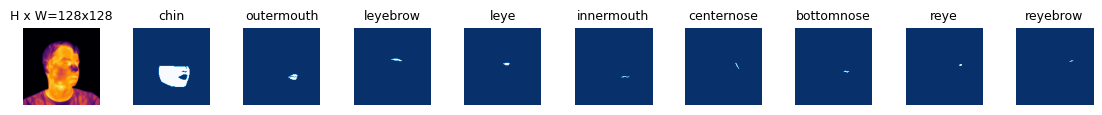

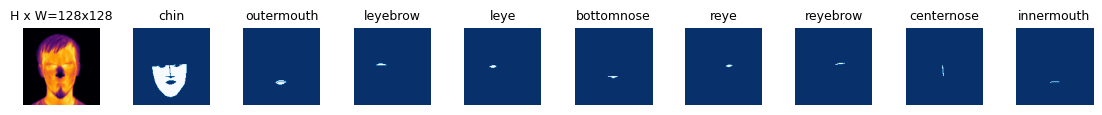

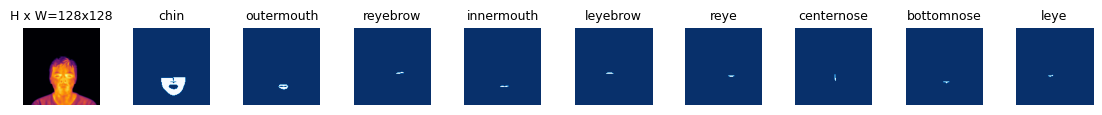

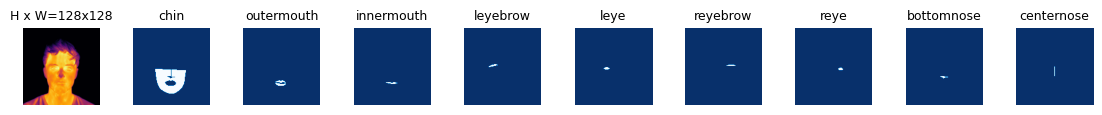

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

for im_id in image_ids:
    image = dataset_train.load_image(im_id)
    mask, class_ids = dataset_train.load_mask(im_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=9)

### Create Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
'''
import pickle
model_info={
    "dim":DIM
}
pickle.dump(model_info,open(os.path.join(MODEL_DIR,'info.pickle'),'wb'))
'''








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


'\nimport pickle\nmodel_info={\n    "dim":DIM\n}\npickle.dump(model_info,open(os.path.join(MODEL_DIR,\'info.pickle\'),\'wb\'))\n'

In [13]:
# Generate the plot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

# change to keras model rather than maskrcnn model because maskrcnn is a custom class
'''
plot_model(model.keras_model, to_file = 'model_shape1.png',
           show_shapes = True,
           show_layer_names = True)
'''
# plot_model(model.keras_model, to_file='model_plot.png',show_shapes=True)

"\nplot_model(model.keras_model, to_file = 'model_shape1.png',\n           show_shapes = True,\n           show_layer_names = True)\n"

### Train

In [14]:

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 152833611954613399
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4010488628
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4202877522434275522
physical_device_desc: "device: 0, name: Quadro P2200, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


True

In [16]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
EPOCHS=450
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=EPOCHS, 
            layers="all")


logs2-full\infrared20230624T0725

Starting at epoch 0. LR=0.0001

Checkpoint Path: logs2-full\infrared20230624T0725\mask_rcnn_infrared_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      










Epoch 1/450
image ids's len:  587
image ids's len:  2348
100/100 [==============================] - 61s 608ms/step - loss: nan - val_loss: nan

Epoch 2/450
100/100 [==============================] - 32s 319ms/step - loss: nan - val_loss: nan
Epoch 3/450
100/100 [==============================] - 33s 325ms/step - loss: nan - val_loss: nan
Epoch 4/450
100/100 [==============================] - 33s 327ms/step - loss: nan - val_loss: 6.9633
Epoch 5/450
100/100 [==============================] - 34s 338ms/step - loss: 5.9910 - val_loss: 5.9984
Epoch 6/450
100/100 [==============================] - 34s 340ms/step - loss: 5.3242 - val_loss: nan
Epoch 7/450
100/100 [==============================] - 34s 341ms/step - loss: 5.2016 - val_loss: 5.5470
Epoch 8/450
100/100 [==============================] - 34s 342ms/step - loss: 4.9788 - val_loss: 5.2125
Epoch 9/450
100/100 [==============================] - 34s 345ms/step - loss: 4.7546 - val_loss: 5.4361
Epoch 10/450
100/100 [===========

In [17]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, f"mask_rcnn_infrared2_{DIM}_{EPOCHS}.h5")
model.keras_model.save_weights(model_path)

### Detection

In [18]:
class InferenceConfig(Infrared2Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR,"logs/shapes20230601T0200/mask_rcnn_shapes_0002.h5")
# model_path = model.find_last()
model_path=os.path.join(MODEL_DIR,f"mask_rcnn_infrared2_{DIM}_{EPOCHS}.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  logs2-full\mask_rcnn_infrared2_128_450.h5


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max:  175.00000  int32
gt_class_id              shape: (9,)                  min:    1.00000  max:    9.00000  int32
gt_bbox                  shape: (9, 4)                min:   38.00000  max:  113.00000  int32
gt_mask                  shape: (128, 128, 9)         min:    0.00000  max:    1.00000  bool


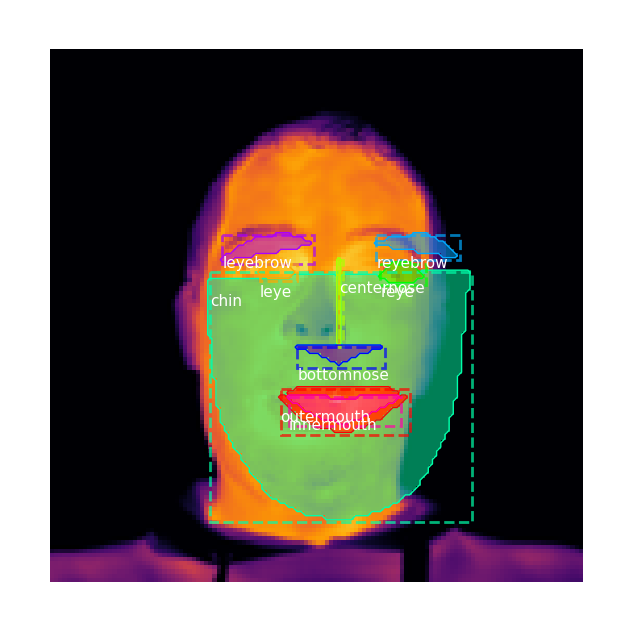

In [19]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


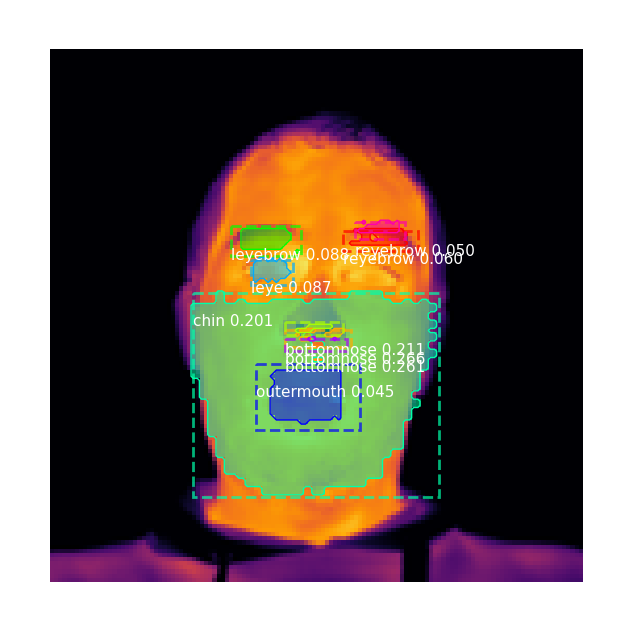

In [20]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

##Evaluation

In [21]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.017870370503515004
